In [2]:
import kagglehub
path = kagglehub.dataset_download("himaniishah/egohands")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/egohands


In [9]:
import cv2
import json
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os
from scipy.io import loadmat
from torchvision import transforms
from PIL import Image
import os
import shutil
import random
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from transformers import pipeline
import re


In [3]:
src = "/kaggle/input/egohands/_LABELLED_SAMPLES"
dst = "/kaggle/working/processed_egohands"

os.makedirs(dst, exist_ok=True)
class_count = 0

for session_folder in sorted(os.listdir(src)):
    session_path = os.path.join(src, session_folder)
    if not os.path.isdir(session_path):
        continue

    mat_path = os.path.join(session_path, 'polygons.mat')
    if not os.path.exists(mat_path):
        continue

    mat = loadmat(mat_path)
    polygons = mat['polygons'][0]

    frame_files = sorted([
        f for f in os.listdir(session_path)
        if f.endswith('.jpg') and f.startswith('frame_')
    ])

    if len(polygons) != len(frame_files):
        print(f"Skipping {session_folder}: mismatch {len(polygons)} polygons vs {len(frame_files)} frames")
        continue

    print(f"\nSession: {session_folder} — {len(polygons)} matched frames")
    selected = list(zip(polygons, frame_files))[:20]

    class_dir = os.path.join(dst, f'class_{class_count:02d}')
    os.makedirs(class_dir, exist_ok=True)

    for j, (polygon, frame_name) in enumerate(selected):
        image_path = os.path.join(session_path, frame_name)
        image = cv2.imread(image_path)
        if image is None:
            continue

        # Saving RGB
        cv2.imwrite(os.path.join(class_dir, f'img_{j:03d}.jpg'), image)

        # Creating binary mask
        height, width = image.shape[:2]
        mask = np.zeros((height, width), dtype=np.uint8)
        for annot in polygon:
            if annot.size > 0:
                pts = annot.reshape(-1, 1, 2).astype(np.int32)
                cv2.fillPoly(mask, [pts], color=255)

        # Saving mask
        cv2.imwrite(os.path.join(class_dir, f'mask_{j:03d}.png'), mask)
        print(f"{frame_name} → img_{j:03d}.jpg + mask_{j:03d}.png")

    class_count += 1
    if class_count >= 50:
        break

print("\nStep 1 complete: RGB + mask pairs saved to /kaggle/working/processed_egohands/")



Session: CARDS_COURTYARD_B_T — 100 matched frames
frame_0011.jpg → img_000.jpg + mask_000.png
frame_0036.jpg → img_001.jpg + mask_001.png
frame_0099.jpg → img_002.jpg + mask_002.png
frame_0113.jpg → img_003.jpg + mask_003.png
frame_0176.jpg → img_004.jpg + mask_004.png
frame_0183.jpg → img_005.jpg + mask_005.png
frame_0184.jpg → img_006.jpg + mask_006.png
frame_0187.jpg → img_007.jpg + mask_007.png
frame_0189.jpg → img_008.jpg + mask_008.png
frame_0206.jpg → img_009.jpg + mask_009.png
frame_0229.jpg → img_010.jpg + mask_010.png
frame_0241.jpg → img_011.jpg + mask_011.png
frame_0295.jpg → img_012.jpg + mask_012.png
frame_0316.jpg → img_013.jpg + mask_013.png
frame_0324.jpg → img_014.jpg + mask_014.png
frame_0333.jpg → img_015.jpg + mask_015.png
frame_0381.jpg → img_016.jpg + mask_016.png
frame_0384.jpg → img_017.jpg + mask_017.png
frame_0484.jpg → img_018.jpg + mask_018.png
frame_0580.jpg → img_019.jpg + mask_019.png

Session: CARDS_COURTYARD_H_S — 100 matched frames
frame_0060.jpg → i

In [4]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import numpy as np

class EgoHandsSegmentationDataset(Dataset):
    def __init__(self, root_dir, image_size=(256, 256)):
        self.samples = []
        self.image_size = image_size

        self.transform_img = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.transform_mask = transforms.Compose([
            transforms.Resize(image_size, interpolation=Image.NEAREST)
        ])

        for class_dir in sorted(os.listdir(root_dir)):
            class_path = os.path.join(root_dir, class_dir)
            if not os.path.isdir(class_path): continue
            for file in os.listdir(class_path):
                if file.startswith("img_") and file.endswith(".jpg"):
                    idx = file.split("_")[1].split(".")[0]
                    mask_path = os.path.join(class_path, f"mask_{idx}.png")
                    img_path = os.path.join(class_path, file)
                    if os.path.exists(mask_path):
                        self.samples.append((img_path, mask_path))

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        image = self.transform_img(image)
        mask = self.transform_mask(mask)
        mask = torch.from_numpy(np.array(mask)).long() // 255  # binary class: 0 or 1
        return image, mask


In [5]:
import torch.nn as nn

class InitialBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels - in_channels, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.prelu = nn.PReLU()

    def forward(self, x):
        return self.prelu(self.bn(torch.cat([self.conv(x), self.pool(x)], 1)))

class DownsampleBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 2, 2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.prelu = nn.PReLU()

    def forward(self, x):
        return self.prelu(self.bn(self.conv(x)))

class ENet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.initial = InitialBlock(3, 16)
        self.down1 = DownsampleBottleneck(16, 64)
        self.down2 = DownsampleBottleneck(64, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.up2 = nn.ConvTranspose2d(64, 16, 2, 2)
        self.final = nn.ConvTranspose2d(16, num_classes, 2, 2)

    def forward(self, x):
        x = self.initial(x)
        x = self.down1(x)
        x = self.down2(x)
        x = self.up1(x)
        x = self.up2(x)
        x = self.final(x)
        return x


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading dataset
dataset = EgoHandsSegmentationDataset("/kaggle/working/processed_egohands")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False)

# Initialize ENet
model = ENet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training
num_epochs = 50
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {train_loss:.4f} — Val Loss: {val_loss:.4f}")

# Saving the model
torch.save(model.state_dict(), "/kaggle/working/enet_egohands.pth")
print("Model saved to enet_egohands.pth")


Epoch 1/50 — Train Loss: 0.3253 — Val Loss: 0.1630
Epoch 2/50 — Train Loss: 0.1465 — Val Loss: 0.1414
Epoch 3/50 — Train Loss: 0.1337 — Val Loss: 0.1340
Epoch 4/50 — Train Loss: 0.1305 — Val Loss: 0.1341
Epoch 5/50 — Train Loss: 0.1275 — Val Loss: 0.1307
Epoch 6/50 — Train Loss: 0.1264 — Val Loss: 0.1294
Epoch 7/50 — Train Loss: 0.1257 — Val Loss: 0.1269
Epoch 8/50 — Train Loss: 0.1237 — Val Loss: 0.1258
Epoch 9/50 — Train Loss: 0.1225 — Val Loss: 0.1257
Epoch 10/50 — Train Loss: 0.1222 — Val Loss: 0.1248
Epoch 11/50 — Train Loss: 0.1213 — Val Loss: 0.1230
Epoch 12/50 — Train Loss: 0.1203 — Val Loss: 0.1227
Epoch 13/50 — Train Loss: 0.1198 — Val Loss: 0.1232
Epoch 14/50 — Train Loss: 0.1182 — Val Loss: 0.1248
Epoch 15/50 — Train Loss: 0.1179 — Val Loss: 0.1208
Epoch 16/50 — Train Loss: 0.1177 — Val Loss: 0.1198
Epoch 17/50 — Train Loss: 0.1167 — Val Loss: 0.1203
Epoch 18/50 — Train Loss: 0.1162 — Val Loss: 0.1182
Epoch 19/50 — Train Loss: 0.1148 — Val Loss: 0.1198
Epoch 20/50 — Train L

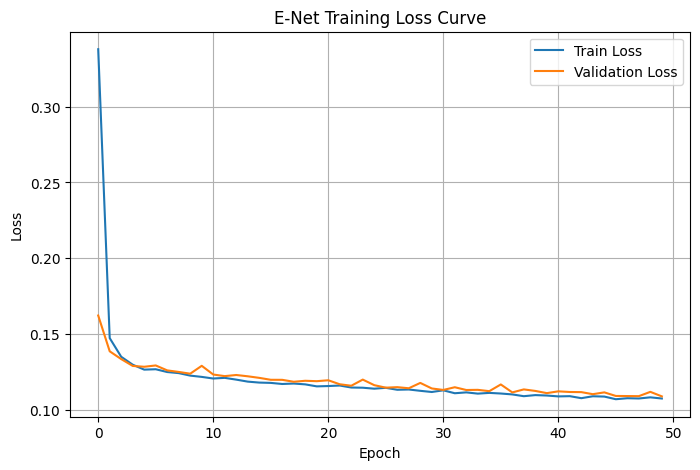

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("E-Net Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


In [26]:
# Loading E-Net
model = ENet(num_classes=2)
model.load_state_dict(torch.load("/kaggle/working/enet_egohands.pth", map_location="cuda" if torch.cuda.is_available() else "cpu"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


/tmp/ipykernel_31/754585739.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/enet_egohands.pth", map_location="cuda" if 

ENet(
  (initial): InitialBlock(
    (conv): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
  )
  (down1): DownsampleBottleneck(
    (conv): Conv2d(16, 64, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
  )
  (down2): DownsampleBottleneck(
    (conv): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
  )
  (up1): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (up2): ConvTranspose2d(64, 16, kernel_size=(2, 2), stride=(2, 2))
  (final): ConvTranspose2d(16, 2, kernel_size=(2, 2), str

In [27]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [9]:
wlasl_processed_path = kagglehub.dataset_download('risangbaskoro/wlasl-processed')

In [28]:
# Input and output paths
video_root = "/kaggle/input/wlasl-processed/videos"
json_path = "/kaggle/input/wlasl-processed/WLASL_v0.3.json"
output_root = "/kaggle/working/wlasl_segmented_enet"
os.makedirs(output_root, exist_ok=True)

# Loading gloss metadata
with open(json_path, 'r') as f:
    wlasl_data = json.load(f)

# Selecting 50 random glosses
all_glosses = sorted({entry["gloss"] for entry in wlasl_data})
import random
random.seed(42)
selected_glosses = random.sample(all_glosses, 50)

video_to_gloss = {}
for entry in wlasl_data:
    if entry["gloss"] not in selected_glosses:
        continue
    for instance in entry["instances"]:
        vid = instance["video_id"]
        video_to_gloss[vid] = entry["gloss"]

print(f"Selected glosses ({len(selected_glosses)}):", selected_glosses[:5])

# Segment frames
for vid_file in tqdm(sorted(os.listdir(video_root))):
    if not vid_file.endswith(".mp4"):
        continue

    video_id = os.path.splitext(vid_file)[0]
    gloss = video_to_gloss.get(video_id)
    if gloss is None:
        continue

    gloss_dir = os.path.join(output_root, gloss)
    os.makedirs(gloss_dir, exist_ok=True)

    cap = cv2.VideoCapture(os.path.join(video_root, vid_file))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < 1:
        continue

    start = int(0.2 * total_frames)
    end = int(0.8 * total_frames)
    frame_indices = np.linspace(start, end, 20).astype(int)

    saved_count = 0
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        rgb_resized = cv2.resize(rgb, (256, 256))
        pil_img = Image.fromarray(rgb_resized)
        input_tensor = transform(pil_img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)[0].argmax(0).cpu().numpy()

        if np.count_nonzero(output == 1) > 5000:
            mask = (output == 1).astype(np.uint8) * 255
            hand = cv2.bitwise_and(rgb_resized, rgb_resized, mask=mask)
            save_path = os.path.join(gloss_dir, f"{video_id}_frame_{saved_count:02d}.jpg")
            cv2.imwrite(save_path, cv2.cvtColor(hand, cv2.COLOR_RGB2BGR))
            saved_count += 1

    cap.release()

print("✅ Done: Segmented frames saved in gloss-labeled folders.")


✅ Selected glosses (50): ['position', 'bracelet', 'alligator', 'sculpture', 'drama']


100%|██████████| 11980/11980 [03:11<00:00, 62.58it/s] 

✅ Done: Segmented frames saved in gloss-labeled folders.


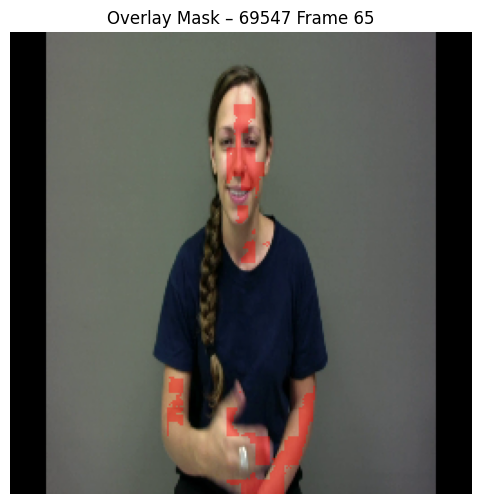

In [29]:
# Resize original RGB frame to match the mask shape
resized_rgb = cv2.resize(rgb, (256, 256))

# Create red mask and overlay
overlay = resized_rgb.copy()
red_mask = np.zeros_like(resized_rgb)
red_mask[:, :, 0] = 255  # Red only

binary_mask = (output == 1).astype(np.uint8)
alpha = 0.4

# Apply red overlay only where mask is 1
overlay = cv2.addWeighted(overlay, 1 - alpha, red_mask, alpha, 0)
overlay[binary_mask == 0] = resized_rgb[binary_mask == 0]  # Restore background

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title(f"Overlay Mask – {video_id} Frame {idx}")
plt.axis('off')
plt.show()


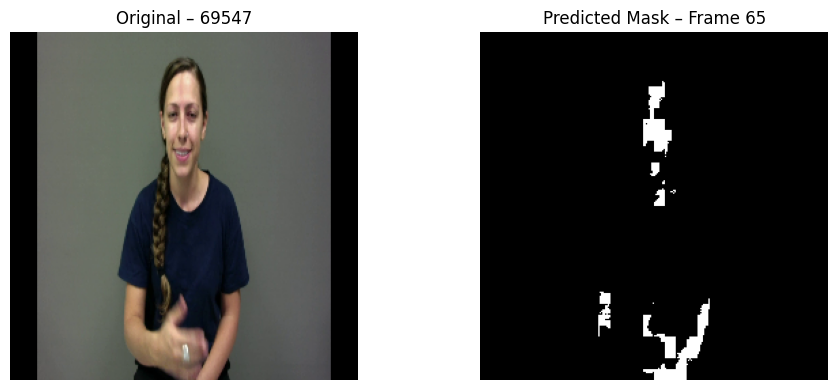

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.resize(rgb, (256, 256))) 
plt.title(f"Original – {video_id}")
plt.axis('off')

# Show predicted mask
plt.subplot(1, 2, 2)
plt.imshow(output, cmap="gray")
plt.title(f"Predicted Mask – Frame {idx}")
plt.axis('off')

plt.tight_layout()
plt.show()


In [32]:
src = "/kaggle/working/wlasl_segmented_enet"
dst = "/kaggle/working/wlasl_segmented_random"
os.makedirs(dst, exist_ok=True)

random.seed(42)
all_glosses = sorted(os.listdir(src))
selected_glosses = random.sample(all_glosses, 50)

for gloss in selected_glosses:
    gloss_src = os.path.join(src, gloss)
    gloss_dst = os.path.join(dst, gloss)
    os.makedirs(gloss_dst, exist_ok=True)
    files = random.sample(os.listdir(gloss_src), min(20, len(os.listdir(gloss_src))))
    for f in files:
        shutil.copy(os.path.join(gloss_src, f), os.path.join(gloss_dst, f))

print("✅ Created random subset at:", dst)


✅ Created random subset at: /kaggle/working/wlasl_segmented_random


In [39]:
import os

print("/kaggle/working contents:")
for item in os.listdir("/kaggle/working"):
    print("📁", item)


✅ /kaggle/working contents:
📁 wlasl_segmented_enet
📁 wlasl_segmented_random
📁 .virtual_documents
📁 processed_egohands
📁 enet_egohands.pth


In [40]:
import os

segmented_path = "/kaggle/working/wlasl_segmented_enet"
gloss_image_counts = {}

for gloss in sorted(os.listdir(segmented_path)):
    gloss_path = os.path.join(segmented_path, gloss)
    if os.path.isdir(gloss_path):
        valid_imgs = [f for f in os.listdir(gloss_path)
                      if os.path.splitext(f)[-1].lower() in [".jpg", ".jpeg", ".png"]]
        gloss_image_counts[gloss] = len(valid_imgs)

# Show glosses with fewer than 5 images
print("Glosses with <5 images:")
for g, count in gloss_image_counts.items():
    if count < 5:
        print(f"{g:15s} : {count}")

# Summary
valid = [g for g, c in gloss_image_counts.items() if c >= 5]
print(f"\nTotal glosses with ≥5 images: {len(valid)}")


⚠️ Glosses with <5 images:
alligator       : 0
alone           : 0
binoculars      : 0
bird            : 0
bone            : 0
bracelet        : 0
cheese          : 0
cry             : 0
curious         : 0
drama           : 0
drive           : 0
fear            : 0
her             : 4
inform          : 2
mosquito        : 0
negotiate       : 0
opposite        : 0
position        : 0
puzzled         : 0
remove          : 0
schedule        : 0
scream          : 0
shovel          : 0
spit            : 0
thank you       : 0
willing         : 0

✅ Total glosses with ≥5 images: 24


In [42]:
import os
from collections import defaultdict

raw_frames_dir = "/kaggle/input/wlaslframes/wlasl_frames"

gloss_data = defaultdict(list)

for gloss in sorted(os.listdir(raw_frames_dir)):
    gloss_path = os.path.join(raw_frames_dir, gloss)
    if not os.path.isdir(gloss_path):
        continue

    for fname in sorted(os.listdir(gloss_path)):
        if fname.endswith((".jpg", ".jpeg", ".png")):
            frame_path = os.path.join(gloss_path, fname)
            video_id = fname.split("_")[0]
            gloss_data[gloss].append((frame_path, video_id))

print(f"✅ Loaded {len(gloss_data)} glosses from frame dataset.")


✅ Loaded 25 glosses from frame dataset.


In [44]:
import os
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch

# Define path to input frames
raw_frames_dir = "/kaggle/input/wlaslframes/wlasl_frames"
output_root = "/kaggle/working/wlasl_segmented_enet"
os.makedirs(output_root, exist_ok=True)

# Build gloss_data: maps each gloss to list of (frame_path, video_id)
from collections import defaultdict
gloss_data = defaultdict(list)

for gloss in sorted(os.listdir(raw_frames_dir)):
    gloss_path = os.path.join(raw_frames_dir, gloss)
    if not os.path.isdir(gloss_path):
        continue
    for fname in sorted(os.listdir(gloss_path)):
        if fname.endswith((".jpg", ".jpeg", ".png")):
            frame_path = os.path.join(gloss_path, fname)
            video_id = fname.split("_")[0]
            gloss_data[gloss].append((frame_path, video_id))

print(f"Loaded {len(gloss_data)} glosses from WLASL frames.")

# Loop through each frame, segment and save
model.eval()

for gloss, frame_entries in tqdm(gloss_data.items()):
    gloss_dir = os.path.join(output_root, gloss)
    os.makedirs(gloss_dir, exist_ok=True)

    for idx, (frame_path, video_id) in enumerate(frame_entries):
        try:
            # Load, convert, resize
            rgb = cv2.imread(frame_path)
            rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
            rgb_resized = cv2.resize(rgb, (256, 256))

            # Convert to PIL for transform
            rgb_pil = Image.fromarray(rgb_resized)
            input_tensor = transform(rgb_pil).unsqueeze(0).to(device)

            # Predict mask
            with torch.no_grad():
                output = model(input_tensor)[0].argmax(0).cpu().numpy()

            # Apply mask to original resized image
            mask = (output == 1).astype(np.uint8) * 255
            segmented = cv2.bitwise_and(rgb_resized, rgb_resized, mask=mask)

            # Save segmented image
            save_path = os.path.join(gloss_dir, f"{video_id}_frame_{idx:03d}.jpg")
            cv2.imwrite(save_path, cv2.cvtColor(segmented, cv2.COLOR_RGB2BGR))

        except Exception as e:
            print(f"Skipped {frame_path}: {e}")

print("Done: Segmented frames saved in /kaggle/working/wlasl_segmented_enet")


✅ Loaded 25 glosses from WLASL frames.


  0%|          | 0/25 [00:00<?, ?it/s]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/before/05727_frame000.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/before/05727_frame001.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/before/05727_frame002.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/before/05727_frame003.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'bina

  4%|▍         | 1/25 [00:10<04:12, 10.54s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/before/05743_frame046.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/book/07068_frame000.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/book/07068_frame001.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/book/07068_frame002.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

  8%|▊         | 2/25 [00:14<02:32,  6.63s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/book/69241_frame067.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/book/69241_frame068.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/book/69241_frame069.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/book/69241_frame070.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'



 12%|█▏        | 3/25 [00:22<02:37,  7.16s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/candy/08925_frame032.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/candy/08925_frame033.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/candy/08925_frame034.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/candy/08925_frame035.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_o

 16%|█▌        | 4/25 [00:26<02:08,  6.14s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/chair/09854_frame029.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/clothes/11309_frame000.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/clothes/11309_frame001.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/clothes/11309_frame002.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'bi

 20%|██        | 5/25 [00:30<01:43,  5.18s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/clothes/11313_frame020.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/clothes/11313_frame021.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/clothes/11313_frame022.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/clothes/11313_frame023.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function '

 24%|██▍       | 6/25 [00:47<02:57,  9.34s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/computer/12328_frame082.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/computer/12328_frame083.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/computer/12328_frame084.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/computer/12328_frame085.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in functi

 28%|██▊       | 7/25 [00:57<02:49,  9.44s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/cousin/13642_frame018.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/cousin/13642_frame019.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/cousin/13642_frame020.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/cousin/13642_frame021.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'bina

 32%|███▏      | 8/25 [01:02<02:19,  8.23s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/deaf/14894_frame038.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/drink/17709_frame000.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/drink/17709_frame001.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/drink/17709_frame002.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op

 36%|███▌      | 9/25 [01:11<02:11,  8.24s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/drink/69302_frame067.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/drink/69302_frame068.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/drink/69302_frame069.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/drink/69302_frame070.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_o

 40%|████      | 10/25 [01:16<01:49,  7.29s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/fine/21883_frame006.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/fine/21883_frame007.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/fine/21883_frame008.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/fine/21883_frame009.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'



 44%|████▍     | 11/25 [01:23<01:42,  7.31s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/go/69345_frame058.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/go/69345_frame059.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/go/69345_frame060.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/go/69345_frame061.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skippe

 48%|████▊     | 12/25 [01:31<01:34,  7.29s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/help/69364_frame069.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/help/69364_frame070.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/help/69364_frame071.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/help/69364_frame072.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'



 52%|█████▏    | 13/25 [01:38<01:27,  7.33s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/mother/69402_frame077.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/mother/69402_frame078.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/mother/69402_frame079.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/mother/69402_frame080.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'bina

 56%|█████▌    | 14/25 [01:51<01:38,  8.95s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/no/69411_frame062.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/no/69411_frame063.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/no/69411_frame064.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/no/69411_frame065.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skippe

 60%|██████    | 15/25 [01:56<01:17,  7.79s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/now/69413_frame059.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/orange/40115_frame000.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/orange/40115_frame001.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/orange/40115_frame002.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_

 64%|██████▍   | 16/25 [02:02<01:04,  7.21s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/orange/69422_frame053.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/orange/69422_frame054.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/orange/69422_frame055.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/orange/69422_frame056.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'bina

 68%|██████▊   | 17/25 [02:05<00:48,  6.07s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/table/56563_frame017.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/table/56563_frame018.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/table/56563_frame019.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/table/56563_frame020.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_o

 72%|███████▏  | 18/25 [02:13<00:45,  6.56s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/thanksgiving/57641_frame028.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/thin/57933_frame000.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/thin/57933_frame001.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/thin/57933_frame002.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'bina

 76%|███████▌  | 19/25 [02:23<00:45,  7.63s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/thin/57949_frame040.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/thin/57949_frame041.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/thin/57949_frame042.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/thin/57949_frame043.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'



 80%|████████  | 20/25 [02:28<00:34,  6.98s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/walk/62170_frame021.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/walk/62170_frame022.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/walk/62170_frame023.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/walk/62170_frame024.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'



 84%|████████▍ | 21/25 [02:35<00:27,  6.81s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/what/69531_frame054.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/what/69531_frame055.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/what/69531_frame056.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/what/69531_frame057.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'



 88%|████████▊ | 22/25 [02:46<00:24,  8.16s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/who/69534_frame062.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/woman/63664_frame000.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/woman/63664_frame001.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/woman/63664_frame002.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

 92%|█████████▏| 23/25 [02:52<00:14,  7.40s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/woman/63673_frame016.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/woman/63673_frame017.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/woman/63673_frame018.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/woman/63673_frame019.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_o

 96%|█████████▌| 24/25 [02:57<00:06,  6.86s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/year/64219_frame009.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/year/64219_frame010.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/year/64219_frame011.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/year/64219_frame012.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'



100%|██████████| 25/25 [03:04<00:00,  7.38s/it]

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/yes/69546_frame061.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/yes/69546_frame062.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/yes/69546_frame063.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Skipped /kaggle/input/wlaslframes/wlasl_frames/yes/69546_frame064.jpg: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'

❌ Sk

In [45]:
!ls /kaggle/working/wlasl_segmented_enet | wc -l


74


In [46]:
import os
import shutil
import random

src = "/kaggle/working/wlasl_segmented_enet"
dst = "/kaggle/working/wlasl_segmented_random"
os.makedirs(dst, exist_ok=True)

valid_ext = [".jpg", ".jpeg", ".png"]
min_images = 10        # minimum required to include gloss
images_per_gloss = 20  # number of images to copy per gloss

# Clean existing
for g in os.listdir(dst):
    shutil.rmtree(os.path.join(dst, g), ignore_errors=True)

valid_glosses = []
for gloss in os.listdir(src):
    gloss_path = os.path.join(src, gloss)
    valid_imgs = [f for f in os.listdir(gloss_path)
                  if os.path.splitext(f)[-1].lower() in valid_ext]
    if len(valid_imgs) >= min_images:
        valid_glosses.append(gloss)

print(f"✅ Found {len(valid_glosses)} glosses with ≥{min_images} images")

# Copy selected images
for gloss in valid_glosses:
    gloss_src = os.path.join(src, gloss)
    gloss_dst = os.path.join(dst, gloss)
    os.makedirs(gloss_dst, exist_ok=True)

    imgs = [f for f in os.listdir(gloss_src)
            if os.path.splitext(f)[-1].lower() in valid_ext]
    selected = random.sample(imgs, min(images_per_gloss, len(imgs)))

    for f in selected:
        shutil.copy(os.path.join(gloss_src, f), os.path.join(gloss_dst, f))

print(f"✅ Rebuilt dataset in: {dst}")


✅ Found 23 glosses with ≥10 images
✅ Rebuilt dataset in: /kaggle/working/wlasl_segmented_random


✅ Detected 23 glosses
📦 Epoch 01/50 | Train Acc: 28.41% | Val Acc: 47.19%
📦 Epoch 02/50 | Train Acc: 69.03% | Val Acc: 74.16%
📦 Epoch 03/50 | Train Acc: 85.51% | Val Acc: 86.52%
📦 Epoch 04/50 | Train Acc: 94.32% | Val Acc: 93.26%
📦 Epoch 05/50 | Train Acc: 95.45% | Val Acc: 89.89%
📦 Epoch 06/50 | Train Acc: 98.86% | Val Acc: 92.13%
📦 Epoch 07/50 | Train Acc: 98.86% | Val Acc: 95.51%
📦 Epoch 08/50 | Train Acc: 98.86% | Val Acc: 95.51%
📦 Epoch 09/50 | Train Acc: 99.43% | Val Acc: 94.38%
📦 Epoch 10/50 | Train Acc: 99.72% | Val Acc: 95.51%
📦 Epoch 11/50 | Train Acc: 99.15% | Val Acc: 94.38%
📦 Epoch 12/50 | Train Acc: 100.00% | Val Acc: 94.38%
⛔ Early stopping at epoch 12
✅ Best model saved to: /kaggle/working/resnet18_best.pth


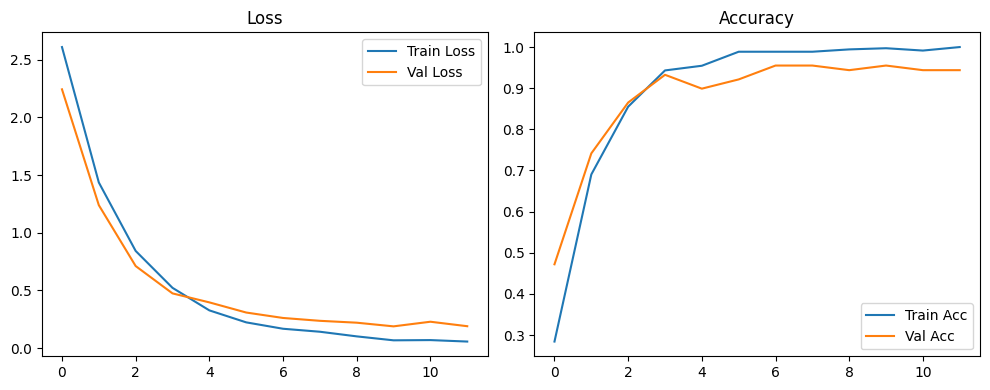

In [48]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Paths
data_root = "/kaggle/working/wlasl_segmented_random"

# Data Augmentation + Normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=data_root, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)
print(f"✅ Detected {num_classes} glosses")

# Train-validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(0.3),  # dropout before final layer
    nn.Linear(model.fc.in_features, num_classes)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop with early stopping
num_epochs = 50
patience = 5
best_val_acc = 0.0
no_improve_epochs = 0
best_model_path = "/kaggle/working/resnet18_best.pth"

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1:02d}/{num_epochs} | "
          f"Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

    # Early Stopping Check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Final Save
print(f"✅ Best model saved to: {best_model_path}")

# Plot results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [49]:
from sklearn.metrics import classification_report

# Put model in evaluation mode
model.eval()

all_preds = []
all_labels = []

# Inference loop on validation set
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Convert class indices to names
used_labels = sorted(set(all_labels + all_preds))
actual_class_names = [class_names[i] for i in used_labels]
print(" Clean Classification Report:")
print(classification_report(
    all_labels,
    all_preds,
    labels=used_labels,
    target_names=actual_class_names
))


 Clean Classification Report:
              precision    recall  f1-score   support

    amputate       1.00      1.00      1.00         3
       angel       1.00      1.00      1.00         4
     benefit       1.00      1.00      1.00         1
       candy       1.00      1.00      1.00         4
     chapter       1.00      1.00      1.00         5
     contact       1.00      0.50      0.67         4
       crazy       1.00      1.00      1.00         1
        cute       0.86      1.00      0.92         6
    december       1.00      1.00      1.00         3
      desert       1.00      1.00      1.00         4
    festival       1.00      1.00      1.00         4
 high school       1.00      1.00      1.00         7
     highway       1.00      1.00      1.00         2
      listen       1.00      0.86      0.92         7
        open       0.83      1.00      0.91         5
       paper       1.00      0.50      0.67         2
       relax       0.80      1.00      0.89        

/tmp/ipykernel_31/1104790653.py:22: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


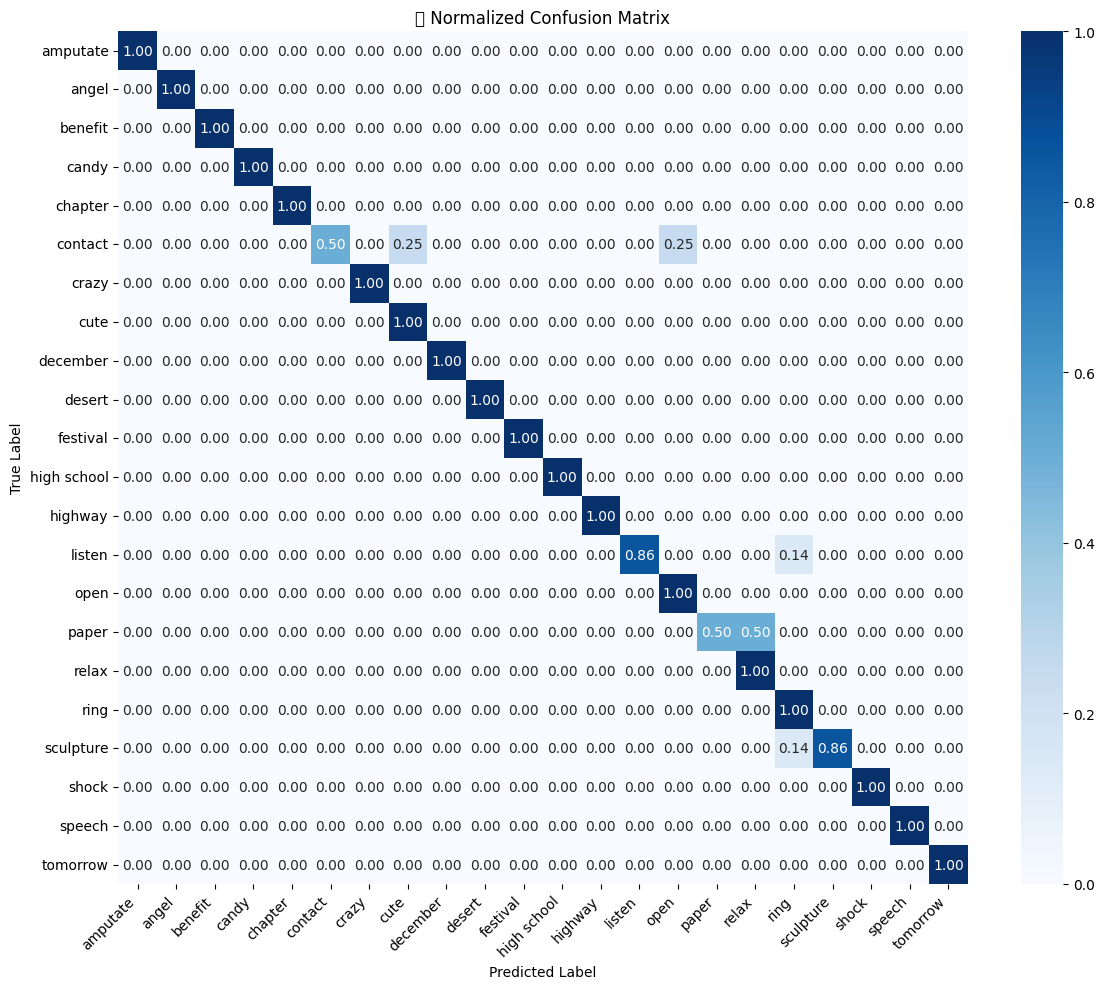

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=used_labels)

# Normalize (optional)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=actual_class_names, yticklabels=actual_class_names)

plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [52]:
# 🔧 Install torchcam if not already
!pip install torchcam -q





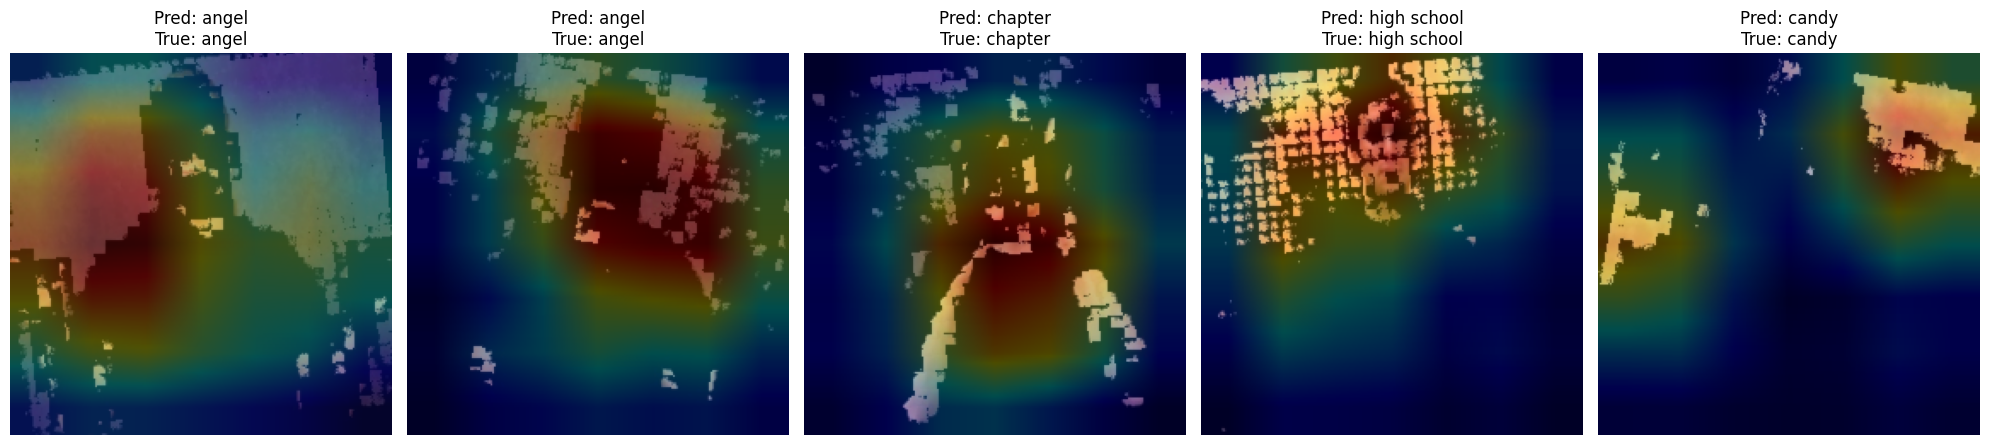

In [53]:
from torchcam.methods import SmoothGradCAMpp
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
from torchvision.transforms.functional import to_pil_image

# Set model to eval mode
model.eval()

# Initialize CAM extractor for ResNet18
cam_extractor = SmoothGradCAMpp(model, target_layer="layer4")

# Sample 5 images from validation set
sample_indices = random.sample(range(len(val_ds)), 5)
plt.figure(figsize=(20, 5))

for i, idx in enumerate(sample_indices):
    image, label = val_ds[idx]
    input_tensor = image.unsqueeze(0).to(device)

    # Forward pass (required by CAM)
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()

    # Extract CAM
    activation_map = cam_extractor(pred_class, output)[0].cpu().numpy()

    # Prepare original image (de-normalize & RGB)
    image_np = image.permute(1, 2, 0).numpy()
    image_np = image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image_np = np.clip(image_np, 0, 1)
    image_np = (image_np * 255).astype(np.uint8)
    image_np_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    image_np_bgr = cv2.resize(image_np_bgr, (224, 224)).astype(np.uint8)

    # Prepare CAM heatmap
    heatmap = cv2.resize(activation_map, (224, 224))
    if heatmap.ndim > 2:
        heatmap = heatmap[0]
    heatmap = (heatmap - np.min(heatmap)) / (np.ptp(heatmap) + 1e-6)
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Ensure shape and channels match
    if len(heatmap_color.shape) == 2:
        heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_GRAY2BGR)
    heatmap_color = cv2.resize(heatmap_color, (224, 224)).astype(np.uint8)

    # Overlay
    overlay = cv2.addWeighted(image_np_bgr, 0.7, heatmap_color, 0.3, 0)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # Show result
    plt.subplot(1, 5, i + 1)
    plt.imshow(overlay_rgb)
    plt.title(f"Pred: {class_names[pred_class]}\nTrue: {class_names[label]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [54]:
!pip install transformers --quiet
!apt-get install -y fonts-noto fonts-noto-unhinted fonts-noto-core fonts-noto-ui-core fonts-noto-color-emoji > /dev/null


In [55]:
from transformers import pipeline
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-hi")


2025-05-06 03:44:40.463436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746503080.651655      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746503080.705638      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/306M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/306M [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/812k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda:0


In [57]:
import re

def translate_gloss_to_hindi(gloss):
    try:
        result = translator(gloss)
        hindi_raw = result[0]['translation_text'].strip()

        # Extract all Devanagari words
        words = re.findall(r'[\u0900-\u097F]+', hindi_raw)

        # Returning the first meaningful word, fallback to full sentence
        if words:
            return words[0]
        else:
            return hindi_raw
    except Exception as e:
        print(f"Translation error for '{gloss}':", e)
        return "[अनुवाद विफल]"


In [58]:
translate_gloss_to_hindi("cheese")


'पनीर'

Device set to use cuda:0
/tmp/ipykernel_31/795028092.py:83: UserWarning: Glyph 108 (l) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_31/795028092.py:83: UserWarning: Glyph 112 (p) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_31/795028092.py:84: UserWarning: Glyph 108 (l) missing from current font.
  plt.savefig("/kaggle/working/gradcam_hindi_overlay.png", dpi=300)
/tmp/ipykernel_31/795028092.py:84: UserWarning: Glyph 112 (p) missing from current font.
  plt.savefig("/kaggle/working/gradcam_hindi_overlay.png", dpi=300)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


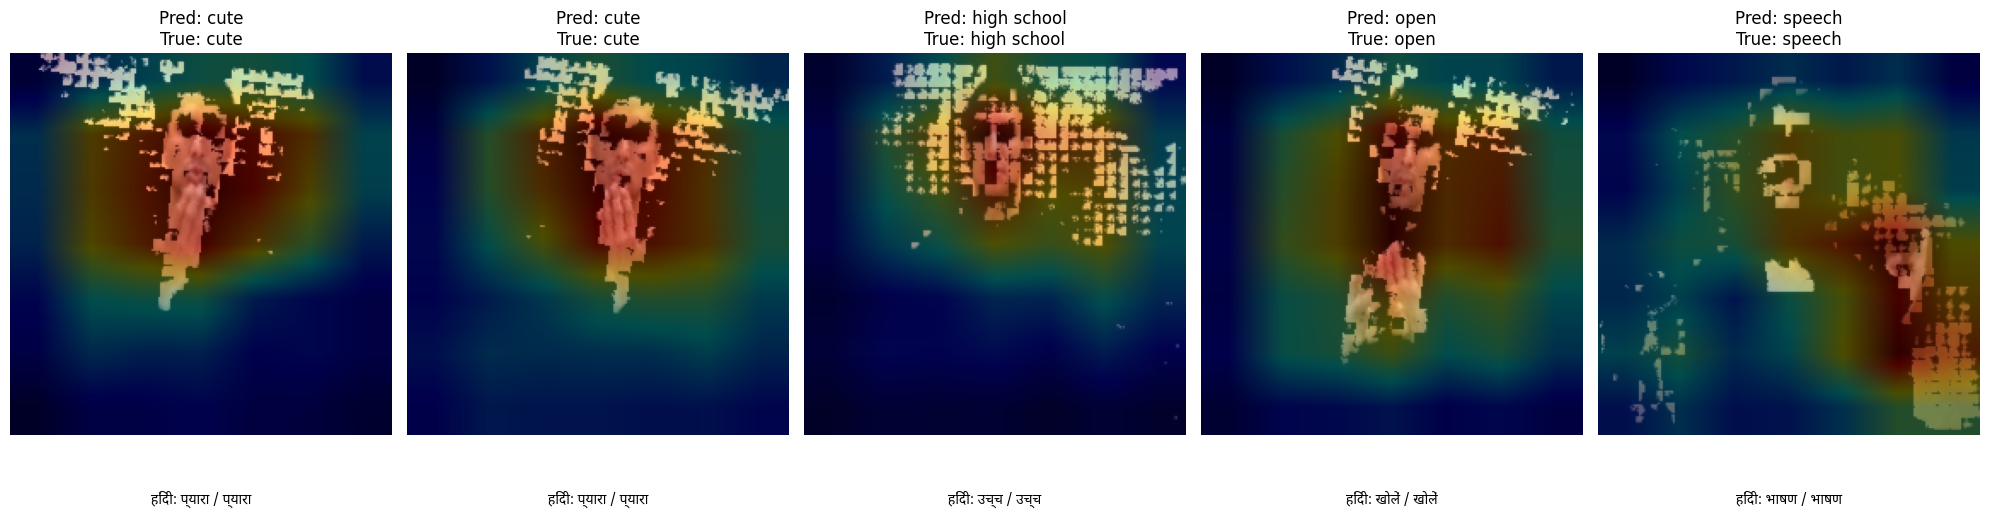

In [59]:
from torchcam.methods import SmoothGradCAMpp
from torchvision.transforms.functional import to_pil_image
from transformers import pipeline
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import torch
# Setup font for Devanagari rendering
font_path = "/usr/share/fonts/truetype/noto/NotoSansDevanagari-Regular.ttf"
hindi_font = fm.FontProperties(fname=font_path)

# Loading English to Hindi translation model
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-hi")

def translate_gloss_to_hindi(gloss):
    """Translate gloss to Hindi and extract the most meaningful word."""
    try:
        result = translator(gloss)
        hindi_raw = result[0]['translation_text'].strip()
        words = re.findall(r'[\u0900-\u097F]+', hindi_raw)
        return words[0] if words else hindi_raw
    except Exception as e:
        print(f"Translation error for '{gloss}':", e)
        return "[अनुवाद विफल]"

# Setup model and Grad-CAM
model.eval()
cam_extractor = SmoothGradCAMpp(model, target_layer="layer4")

# Random 5 samples from validation set
sample_indices = random.sample(range(len(val_ds)), 5)
plt.figure(figsize=(20, 6))

for i, idx in enumerate(sample_indices):
    image, label = val_ds[idx]
    input_tensor = image.unsqueeze(0).to(device)

    # Inference
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    
    pred_gloss = class_names[pred_class]
    true_gloss = class_names[label]

    pred_hindi = translate_gloss_to_hindi(pred_gloss)
    true_hindi = translate_gloss_to_hindi(true_gloss)

    # Grad-CAM map
    activation_map = cam_extractor(pred_class, output)[0].cpu().numpy()
    heatmap = cv2.resize(activation_map, (224, 224))
    if heatmap.ndim > 2:
        heatmap = heatmap[0]
    heatmap = (heatmap - np.min(heatmap)) / (np.ptp(heatmap) + 1e-6)
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Preparing image
    image_np = image.permute(1, 2, 0).numpy()
    image_np = image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image_np = np.clip(image_np, 0, 1)
    image_np = (image_np * 255).astype(np.uint8)
    image_np_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    image_np_bgr = cv2.resize(image_np_bgr, (224, 224))

    # Overlay heatmap
    heatmap_color = cv2.resize(heatmap_color, (224, 224))
    overlay = cv2.addWeighted(image_np_bgr, 0.7, heatmap_color, 0.3, 0)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # Plot
    ax = plt.subplot(1, 5, i + 1)
    ax.imshow(overlay_rgb)
    ax.set_title(f"Pred: {pred_gloss}\nTrue: {true_gloss}", fontsize=12)
    ax.text(0.5, -0.18, f"हिंदी: {pred_hindi} / {true_hindi}", fontproperties=hindi_font,
            fontsize=10, ha='center', transform=ax.transAxes)
    ax.axis("off")

plt.tight_layout()
plt.savefig("/kaggle/working/gradcam_hindi_overlay.png", dpi=300)
plt.show()


In [60]:
import os
gloss_folders = sorted(os.listdir("/kaggle/working/wlasl_segmented_enet"))
print(gloss_folders)


['action', 'alligator', 'alone', 'amputate', 'angel', 'before', 'benefit', 'binoculars', 'bird', 'bone', 'book', 'bracelet', 'candy', 'chair', 'chapter', 'cheese', 'clothes', 'computer', 'contact', 'cousin', 'crazy', 'cry', 'curious', 'cute', 'deaf', 'december', 'desert', 'drama', 'drink', 'drive', 'fear', 'festival', 'fine', 'go', 'help', 'her', 'high school', 'highway', 'inform', 'listen', 'mosquito', 'mother', 'negotiate', 'no', 'now', 'open', 'opposite', 'orange', 'paper', 'position', 'pregnant', 'puzzled', 'relax', 'remove', 'ring', 'schedule', 'scream', 'sculpture', 'shock', 'shovel', 'speech', 'spit', 'table', 'thank you', 'thanksgiving', 'thin', 'tomorrow', 'walk', 'what', 'who', 'willing', 'woman', 'year', 'yes']


In [61]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from transformers import pipeline
your_glosses = [
    'action', 'alligator', 'alone', 'amputate', 'angel', 'before', 'benefit', 'binoculars',
    'bird', 'bone', 'book', 'bracelet', 'candy', 'chair', 'chapter', 'cheese', 'clothes',
    'computer', 'contact', 'cousin', 'crazy', 'cry', 'curious', 'cute', 'deaf', 'december',
    'desert', 'drama', 'drink', 'drive', 'fear', 'festival', 'fine', 'go', 'help', 'her',
    'high school', 'highway', 'inform', 'listen', 'mosquito', 'mother', 'negotiate', 'no',
    'now', 'open', 'opposite', 'orange', 'paper', 'position', 'pregnant', 'puzzled', 'relax',
    'remove', 'ring', 'schedule', 'scream', 'sculpture', 'shock', 'shovel', 'speech', 'spit',
    'table', 'thank you', 'thanksgiving', 'thin', 'tomorrow', 'walk', 'what', 'who', 'willing',
    'woman', 'year', 'yes'
]

# Load translation pipeline
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-hi")

# Setup metrics
smoothie = SmoothingFunction().method1
bleu_scores = []
exact_match_count = 0

print("\nTranslation Evaluation:\n")

for gloss in your_glosses:
    try:
        result = translator(gloss)
        translated = result[0]['translation_text'].strip()
    except Exception as e:
        print(f"Translation error for '{gloss}': {e}")
        continue

    # Extract Devanagari words only
    pred_words = re.findall(r'[\u0900-\u097F]+', translated)

    # Use the first word as reference for self-matching
    reference = [pred_words] if pred_words else [[]]
    candidate = pred_words

    bleu = sentence_bleu(reference, candidate, weights=(1.0, 0, 0, 0), smoothing_function=smoothie) if candidate else 0
    bleu_scores.append(bleu)

    exact = (len(candidate) > 0 and candidate[0] == gloss)  # optional: customize
    exact_match_count += int(exact)

    print(f"Gloss: {gloss}")
    print(f"Hindi : {translated}")
    print(f"BLEU-1 Score: {bleu:.2f}")
    print("—" * 40)

# Summary
total = len(bleu_scores)
print(f"\nTotal glosses: {total}")
print(f"Avg BLEU-1 Score: {np.mean(bleu_scores):.2f}")


Device set to use cuda:0



📊 Translation Evaluation:

Gloss: action
Hindi : क्रिया
BLEU-1 Score: 1.00
————————————————————————————————————————
Gloss: alligator
Hindi : machoghano. kgm
BLEU-1 Score: 0.00
————————————————————————————————————————
Gloss: alone
Hindi : अकेले
BLEU-1 Score: 1.00
————————————————————————————————————————
Gloss: amputate
Hindi : तैयार किया जा रहा है
BLEU-1 Score: 1.00
————————————————————————————————————————
Gloss: angel
Hindi : स्वर्गदूत
BLEU-1 Score: 1.00
————————————————————————————————————————
Gloss: before
Hindi : पहले
BLEU-1 Score: 1.00
————————————————————————————————————————
Gloss: benefit
Hindi : लाभ
BLEU-1 Score: 1.00
————————————————————————————————————————
Gloss: binoculars
Hindi : ग्लोबुलर
BLEU-1 Score: 1.00
————————————————————————————————————————
Gloss: bird
Hindi : पक्षी
BLEU-1 Score: 1.00
————————————————————————————————————————


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Gloss: bone
Hindi : हड्डी
BLEU-1 Score: 1.00
————————————————————————————————————————
Gloss: book
Hindi : किताब
BLEU-1 Score: 1.00
————————————————————————————————————————
Gloss: bracelet
Hindi : रंग: (l)
BLEU-1 Score: 1.00
————————————————————————————————————————
Gloss: candy
Hindi : जोड़ा गया
BLEU-1 Score: 1.00
————————————————————————————————————————
Gloss: chair
Hindi : कुर्सी
BLEU-1 Score: 1.00
————————————————————————————————————————
Gloss: chapter
Hindi : अध्याय
BLEU-1 Score: 1.00
————————————————————————————————————————
Gloss: cheese
Hindi : पनीर
BLEU-1 Score: 1.00
————————————————————————————————————————
Gloss: clothes
Hindi : रंग
BLEU-1 Score: 1.00
————————————————————————————————————————
Gloss: computer
Hindi : कम्प्यूटर
BLEU-1 Score: 1.00
————————————————————————————————————————
Gloss: contact
Hindi : संपर्क
BLEU-1 Score: 1.00
————————————————————————————————————————
Gloss: cousin
Hindi : चचेरा भाई
BLEU-1 Score: 1.00
————————————————————————————————————————
Gloss: crazy
Hin